In [1]:
from astropy.table import Table, hstack, vstack, unique
from astropy import units as u
import astropy.coordinates as coord
from collections import Counter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import pickle
import matplotlib
from pm_func_edr3 import *
from copy import copy
import scipy.ndimage

In [2]:
dir = 'D:/pzivi/Research/Gurtina_Project/'

#Model1, Model2, ModelIso

data = "allstar_Model2_Gas" #DM, Gas, old, young
#perm = "Model 2 old stars"
perm = "Model 2 Gas"

model = Table.read(dir + "Data/"+data+".fits")

print("Number of " + perm + " is " + str(len(model)))

####

importcen = False
importdata = "allstar_Model1_DM"

usemedian = True

plotdir = "Med"

####
   #
####

saveprop = True

properties = []
propnames = []

####
   #
####

                        #old, young, gas, all, DM
plotc = "darkviolet"  #tomato, royalblue, darkviolet, darkblue
plotsize = 12

font = {'family' : 'Times New Roman',
        'size'   : 20}
matplotlib.rc('font', **font)

contourcolor = 'darkslategray'

print(model.info())

Number of Model 2 Gas is 268687
<Table length=268687>
 name   dtype 
------ -------
 X_sim float64
 Y_sim float64
 Z_sim float64
Vx_sim float64
Vy_sim float64
Vz_sim float64
   X_0 float64
   Y_0 float64
   Z_0 float64
  Vx_0 float64
  Vy_0 float64
  Vz_0 float64
   X_G float64
   Y_G float64
   Z_G float64
  Vx_G float64
  Vy_G float64
  Vz_G float64
    RA float64
   DEC float64
  Dist float64
  PMRA float64
 PMDEC float64
    RV float64
None


In [3]:
####
   # Set plotting bounds for the position and proper motion plots
####

displayvals = []

xmin, xmax, ymin, ymax, zmin, zmax, yslitmin, yslitmax, rvmin, rvmax = \
-3.0, 3.0, -3.0, 3.0, -3.0, 3.0, -1.0, 1.0, -63.0, 63.0

displayvals.append(xmin)
displayvals.append(xmax)
displayvals.append(ymin)
displayvals.append(ymax)

## Set bin widths

xwidth, ywidth, zwidth = 0.4, 0.4, 0.4 #0.2, 0.2

displayvals.append(xwidth)
displayvals.append(ywidth)


## Create the array for the slit window

slitwindow = np.asarray([[xmin, yslitmin], [xmax, yslitmin], [xmax, yslitmax], [xmin, yslitmax], [xmin, yslitmin]])

In [4]:
if (importcen):
    newcen = np.loadtxt("")
    xi, yi, zi, vxi, vyi, vzi, lxi, lyi, lzi = 0, 1, 2, 3, 4, 5, 6, 7, 8
    model['X_0'] = model['X_sim'] - newcen[xi]
    model['Y_0'] = model['Y_sim'] - newcen[yi]
    model['Z_0'] = model['Z_sim'] - newcen[zi]
    model['Vx_0'] = model['Vx_sim'] - newcen[vxi]
    model['Vy_0'] = model['Vy_sim'] - newcen[vyi]
    model['Vz_0'] = model['Vz_sim'] - newcen[vzi]
    
else:
    if (usemedian):
        
        tempx = model['X_sim'] - np.median(model['X_sim'])
        tempy = model['Y_sim'] - np.median(model['Y_sim'])
        tempz = model['Z_sim'] - np.median(model['Z_sim'])
        
        model['X_0'] = model['X_sim'] - np.median(model['X_sim'])
        model['Y_0'] = model['Y_sim'] - np.median(model['Y_sim'])
        model['Z_0'] = model['Z_sim'] - np.median(model['Z_sim'])
        model['Vx_0'] = model['Vx_sim'] - np.median(model['Vx_sim'])
        model['Vy_0'] = model['Vy_sim'] - np.median(model['Vy_sim'])
        model['Vz_0'] = model['Vz_sim'] - np.median(model['Vz_sim'])
        
        temp = model[(abs(tempx) < medxcut) & (abs(tempy) < medycut) & (abs(tempz) < medzcut)]
        
        model['X_0'] = model['X_sim'] - np.median(temp['X_sim'])
        model['Y_0'] = model['Y_sim'] - np.median(temp['Y_sim'])
        model['Z_0'] = model['Z_sim'] - np.median(temp['Z_sim'])
        model['Vx_0'] = model['Vx_sim'] - np.median(temp['Vx_sim'])
        model['Vy_0'] = model['Vy_sim'] - np.median(temp['Vy_sim'])
        model['Vz_0'] = model['Vz_sim'] - np.median(temp['Vz_sim'])
        
        
        if (saveprop):
            properties.append(np.median(temp['X_sim']))
            propnames.append('Xcen')
    
            properties.append(np.median(temp['Y_sim']))
            propnames.append('Ycen')
    
            properties.append(np.median(temp['Z_sim']))
            propnames.append('Zcen')
    
            properties.append(np.median(temp['Vx_sim']))
            propnames.append('Vxcen')
    
            properties.append(np.median(temp['Vy_sim']))
            propnames.append('Vycen')
    
            properties.append(np.median(temp['Vz_sim']))
            propnames.append('Vzcen')

In [5]:
#### Set some limits for the data that I'll work with

print(len(model))

model = model[(abs(model['X_0']) < xmax) & (abs(model['Y_0']) < ymax) & (abs(model['Z_0']) < zmax)]

print(len(model))

268687
111961


In [6]:
#### Now start gridding the stars

my_cmap = copy(cm.get_cmap('viridis'))
my_cmap.set_under('w')

<Figure size 432x288 with 0 Axes>

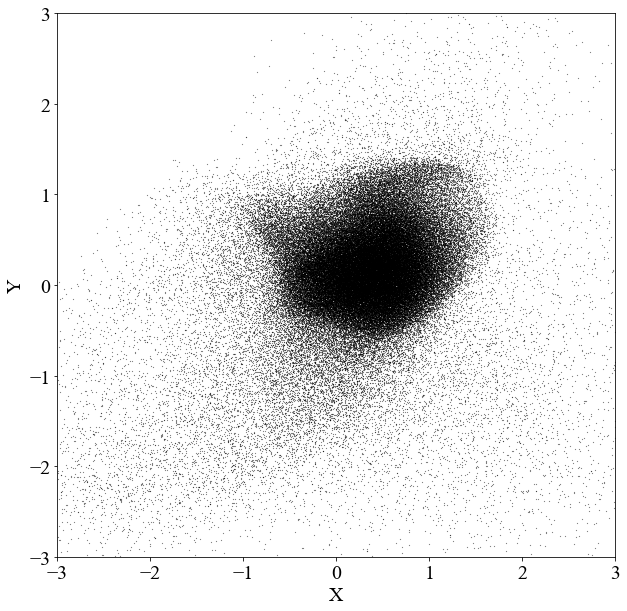

<Figure size 432x288 with 0 Axes>

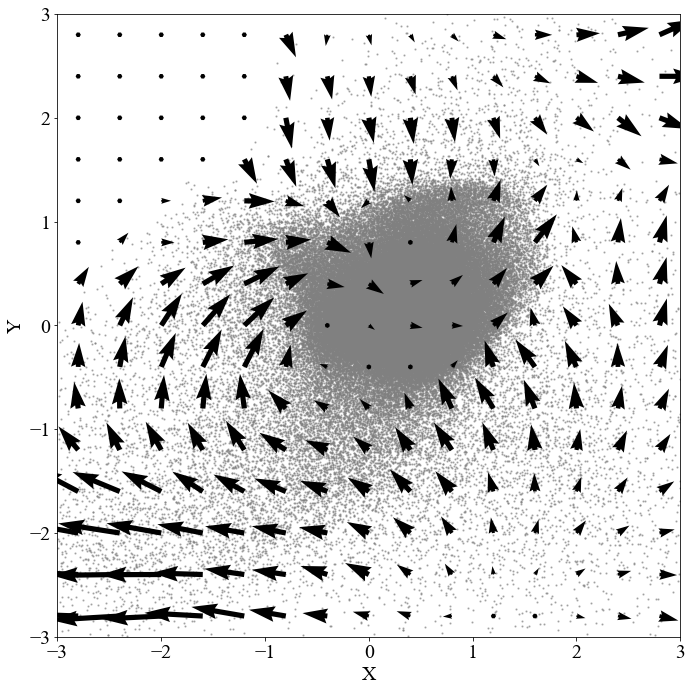

<Figure size 432x288 with 0 Axes>

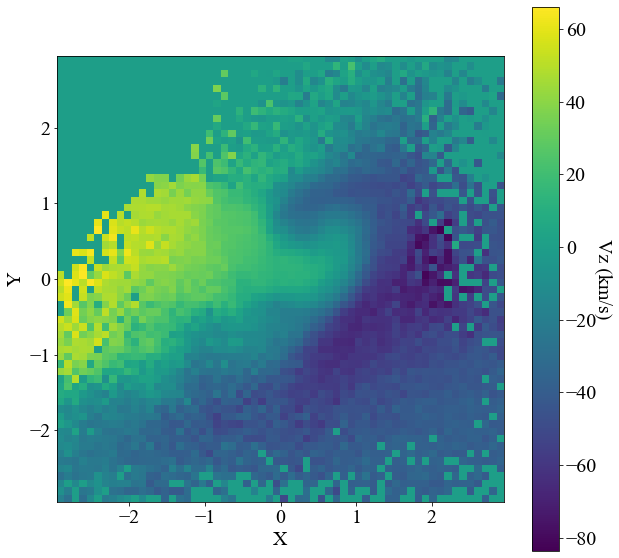

<Figure size 432x288 with 0 Axes>

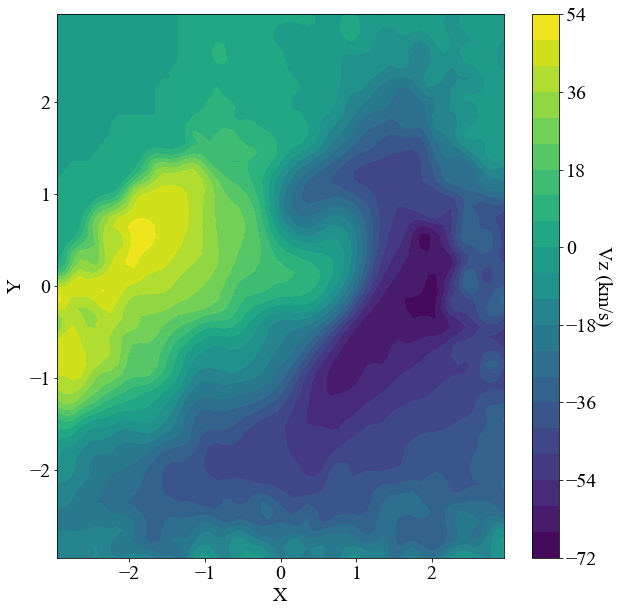

In [7]:
#### First make a scatter plot of the stars in X/Y

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model['X_0'], model['Y_0'], s=6, lw=0, marker='.', color='black', alpha=0.5)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()


#### Next we'll bin the stars in this X/Y space and create Vx/Vy vectors to see the motion in the sky

pmbins = vec_grid(model, xwidth, xmax, xmin, ywidth, ymax, ymin, 'X_0', 'Y_0', 'Vx_0', 'Vy_0')

pmbinx, pmbiny, pmbinpmx, pmbinpmy = 0, 1, 2, 3


#### With vectors calculated, we'll take a look at them now

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model['X_0'], model['Y_0'], s=6, color="grey", marker=".", alpha=0.5)

q1 = ax.quiver(pmbins[:,pmbinx], pmbins[:,pmbiny], \
                (pmbins[:,pmbinpmx]), \
                (pmbins[:,pmbinpmy]), lw=2, \
                units="xy", scale_units='xy', color='black', \
                width=0.05)

ax.set_xlabel(r'X')
ax.set_ylabel(r'Y')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
       
ax.set_aspect("equal")
plt.tight_layout()
plt.show()


#### Now we'll bin the stars in this X/Y space and calculate the average Vz_0 value in each bin

xy_xgrid, xy_ygrid, xy_vzgrid = create_grid(model, 0.1, xmax, xmin, 0.1, \
                                    ymax, ymin, 'X_0', 'Y_0', zind='Vz_0')

distextent = (np.amin(xy_xgrid), np.amax(xy_xgrid), \
              np.amin(xy_ygrid), np.amax(xy_ygrid))


#### Now plot this map

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(xy_vzgrid, extent=distextent, origin='lower', \
                interpolation='nearest', cmap=my_cmap)

cbar = fig.colorbar(cax)
cbar.set_label("Vz (km/s)", rotation=270, labelpad=15)

ax.set_xlim(distextent[0], distextent[1])
ax.set_ylim(distextent[2], distextent[3])

ax.set_xlabel(r'X')
ax.set_ylabel(r'Y')

plt.show()


#### Now smooth it and plot it as a contour map

sigma=1.0
temp_vz = scipy.ndimage.filters.gaussian_filter(xy_vzgrid, sigma)

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

cp = ax.contourf(xy_xgrid, xy_ygrid, temp_vz, levels=20)

cbar = fig.colorbar(cp)
cbar.set_label("Vz (km/s)", rotation=270, labelpad=15)

ax.set_xlim(distextent[0], distextent[1])
ax.set_ylim(distextent[2], distextent[3])

ax.set_xlabel(r'X')
ax.set_ylabel(r'Y')

plt.show()

<Figure size 432x288 with 0 Axes>

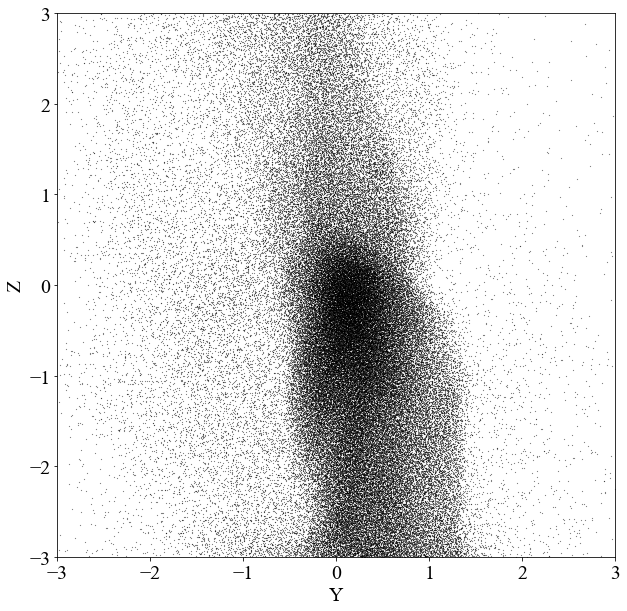

<Figure size 432x288 with 0 Axes>

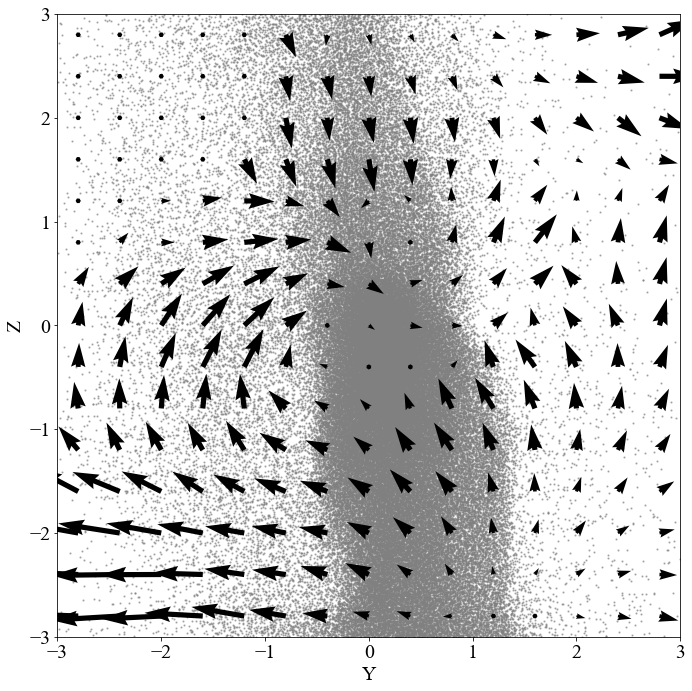

<Figure size 432x288 with 0 Axes>

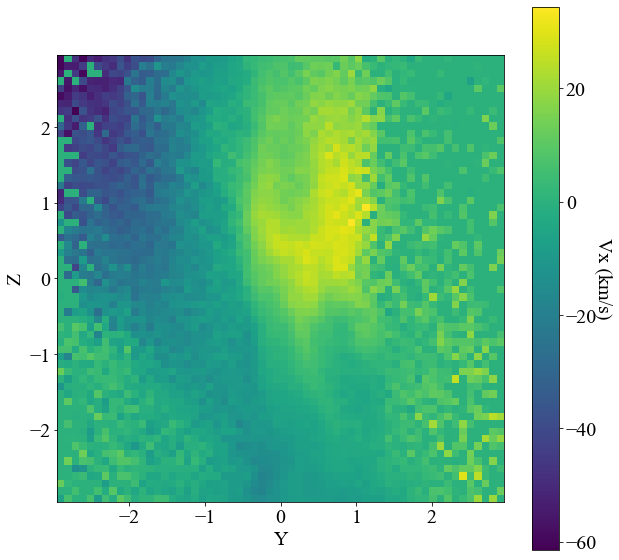

<Figure size 432x288 with 0 Axes>

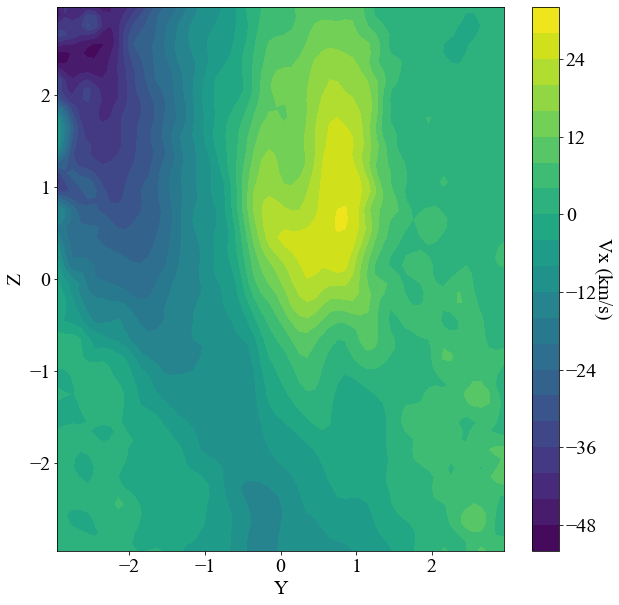

In [8]:
#### First make a scatter plot of the stars in X/Y

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model['Y_0'], model['Z_0'], s=6, lw=0, marker='.', color='black', alpha=0.5)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_xlabel('Y')
ax.set_ylabel('Z')

plt.show()


#### Next we'll bin the stars in this X/Y space and create Vx/Vy vectors to see the motion in the sky

yz_pmbins = vec_grid(model, ywidth, ymax, ymin, zwidth, zmax, zmin, 'Y_0', 'Z_0', 'Vy_0', 'Vz_0')

pmbiny, pmbinz, pmbinvy, pmbinvz = 0, 1, 2, 3


#### With vectors calculated, we'll take a look at them now

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model['Y_0'], model['Z_0'], s=6, color="grey", marker=".", alpha=0.5)

q1 = ax.quiver(yz_pmbins[:,pmbiny], pmbins[:,pmbinz], \
                (pmbins[:,pmbinvy]), \
                (pmbins[:,pmbinvz]), lw=2, \
                units="xy", scale_units='xy', color='black', \
                width=0.05)

ax.set_xlabel(r'Y')
ax.set_ylabel(r'Z')

ax.set_xlim(ymin, ymax)
ax.set_ylim(zmin, zmax)
       
ax.set_aspect("equal")
plt.tight_layout()
plt.show()


#### Now we'll bin the stars in this X/Y space and calculate the average Vz_0 value in each bin

yz_ygrid, yz_zgrid, yz_vxgrid = create_grid(model, 0.1, ymax, ymin, 0.1, \
                                    zmax, zmin, 'Y_0', 'Z_0', zind='Vx_0')

distextent = (np.amin(yz_ygrid), np.amax(yz_ygrid), \
              np.amin(yz_zgrid), np.amax(yz_zgrid))


#### Now plot this map

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(yz_vxgrid, extent=distextent, origin='lower', \
                interpolation='nearest', cmap=my_cmap)

cbar = fig.colorbar(cax)
cbar.set_label("Vx (km/s)", rotation=270, labelpad=15)

ax.set_xlim(distextent[0], distextent[1])
ax.set_ylim(distextent[2], distextent[3])

ax.set_xlabel(r'Y')
ax.set_ylabel(r'Z')

plt.show()


#### Now smooth it and plot it as a contour map

sigma=1.0
temp_vx = scipy.ndimage.filters.gaussian_filter(yz_vxgrid, sigma)

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

cp = ax.contourf(yz_ygrid, yz_zgrid, temp_vx, levels=20)

cbar = fig.colorbar(cp)
cbar.set_label("Vx (km/s)", rotation=270, labelpad=15)

ax.set_xlim(distextent[0], distextent[1])
ax.set_ylim(distextent[2], distextent[3])

ax.set_xlabel(r'Y')
ax.set_ylabel(r'Z')

plt.show()

In [9]:
if (importcen):
    angmom_unit = np.asarray([newcen[lxi], newcen[lyi], newcen[lzi]])

    
else:
    model_pos = np.asarray([model['X_0'], model['Y_0'], model['Z_0']]).T

    model_vel = np.asarray([model['Vx_0'], model['Vy_0'], model['Vz_0']]).T

    angmom = np.zeros((len(model),3))

    for a in range(len(model)):
        angmom[a] = np.cross(model_pos[a], model_vel[a])
    
    angmom_avgmag = np.sqrt((np.average(angmom[:,0]))**2 + (np.average(angmom[:,1]))**2 + (np.average(angmom[:,2]))**2)

    angmom_unit = np.asarray([np.average(angmom[:,0])/angmom_avgmag, np.average(angmom[:,1])/angmom_avgmag, \
                          np.average(angmom[:,2])/angmom_avgmag])
    
    
    

In [10]:
# Calculate angle between unit vector and the z-axis in the yz frame

x, y, z = 0, 1, 2

xrot_mag = np.sqrt(angmom_unit[y]**2 + angmom_unit[z]**2)

xrot_ang = np.arccos(np.dot([angmom_unit[y], angmom_unit[z]], [0.0, 1.0])/xrot_mag)
if (angmom_unit[y] < 0.0):
    xrot_ang = -1.0 * xrot_ang

temp_pos = np.zeros((len(model), 3))
temp_vel = np.zeros((len(model), 3))

for a in range(len(model)):
    temp_pos[a] = np.matmul(rot_xaxis(xrot_ang), model_pos[a])
    temp_vel[a] = np.matmul(rot_xaxis(xrot_ang), model_vel[a])

new_angmom_unit = np.matmul(rot_xaxis(xrot_ang), angmom_unit)

In [11]:
yrot_mag = np.sqrt(new_angmom_unit[x]**2 + new_angmom_unit[z]**2)

yrot_ang = np.arccos(np.dot([new_angmom_unit[x], new_angmom_unit[z]], [0.0, 1.0])/yrot_mag)
if (new_angmom_unit[x] > 0.0):
    yrot_ang = -1*yrot_ang
    
new_pos = np.zeros((len(model), 3))
new_vel = np.zeros((len(model), 3))

for a in range(len(model)):
    new_pos[a] = np.matmul(rot_yaxis(yrot_ang), temp_pos[a])
    new_vel[a] = np.matmul(rot_yaxis(yrot_ang), temp_vel[a])

final_angmom_unit = np.matmul(rot_yaxis(yrot_ang), new_angmom_unit)

In [12]:
try:
    model.add_column(new_pos[:,x], name='X_1')
    model.add_column(new_pos[:,y], name='Y_1')
    model.add_column(new_pos[:,z], name='Z_1')
    model.add_column(new_vel[:,x], name='Vx_1')
    model.add_column(new_vel[:,y], name='Vy_1')
    model.add_column(new_vel[:,z], name='Vz_1')
    
except ValueError:
    print("Already added these columns.")

<Figure size 432x288 with 0 Axes>

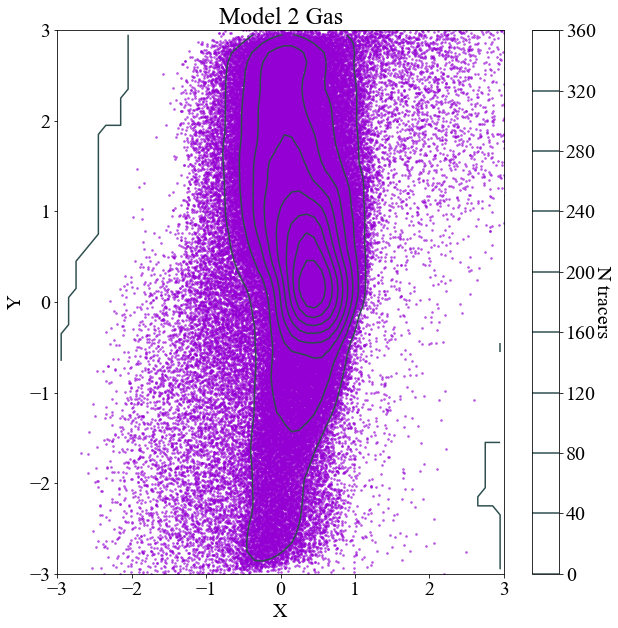

<Figure size 432x288 with 0 Axes>

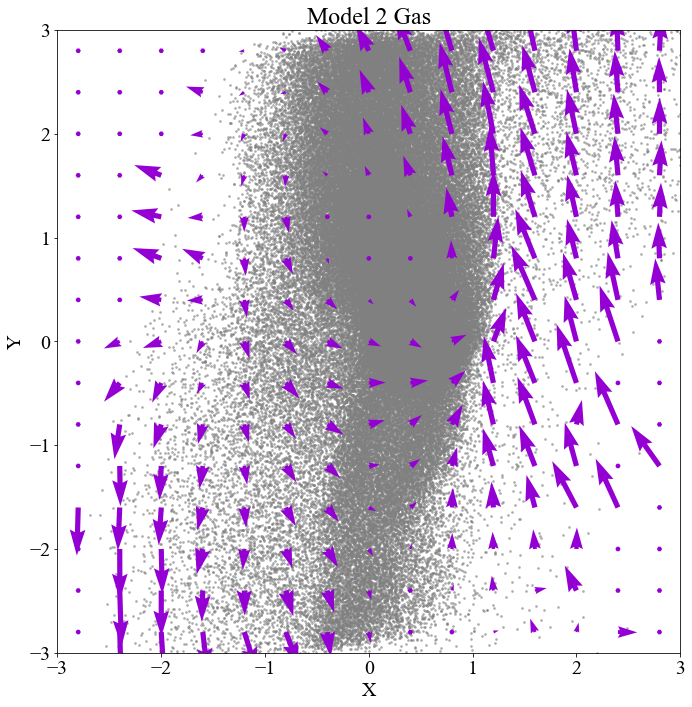

<Figure size 432x288 with 0 Axes>

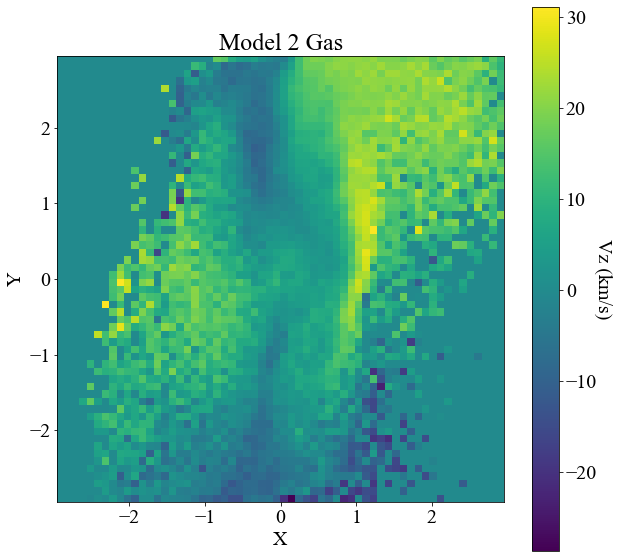

<Figure size 432x288 with 0 Axes>

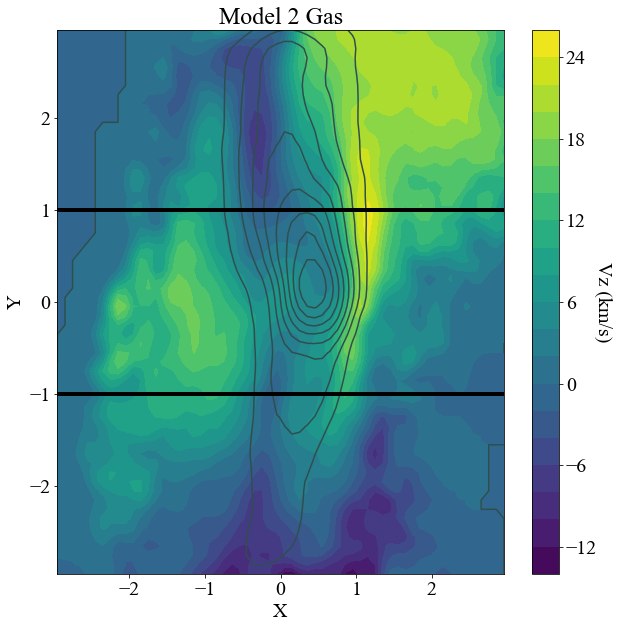

<Figure size 432x288 with 0 Axes>

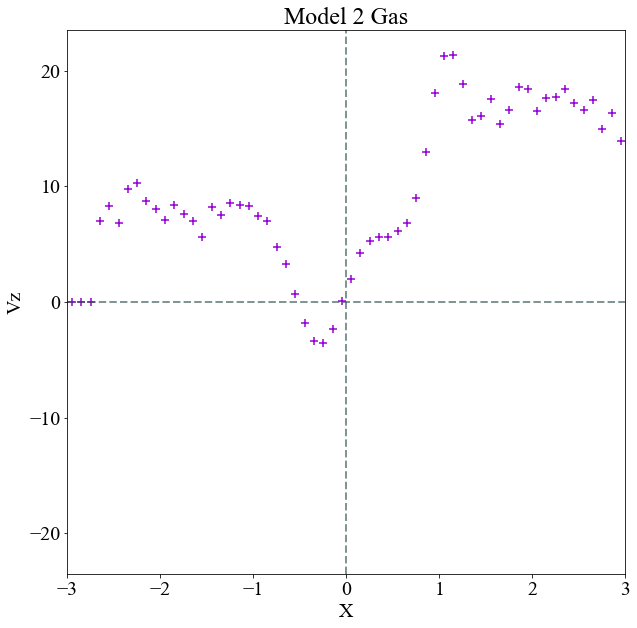

In [13]:
xy_xgrid2, xy_ygrid2, xy_ngrid2 = create_grid(model, 0.1, xmax, xmin, 0.1, \
                                             ymax, ymin, 'X_1', 'Y_1', countn=True)

sigma=1.0

temp_n = scipy.ndimage.filters.gaussian_filter(xy_ngrid2, sigma)

#### First make a scatter plot of the stars in X/Y

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model['X_1'], model['Y_1'], s=plotsize, marker='.', color=plotc, alpha=0.5)
cn = ax.contour(xy_xgrid2, xy_ygrid2, temp_n, levels=10, colors=contourcolor)

cbar = fig.colorbar(cn)
cbar.set_label("N tracers", rotation=270, labelpad=15)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_xlabel('X')
ax.set_ylabel('Y')

ax.set_title(perm)

fig.savefig(dir + "Plots/"+plotdir+"/" + data + "_XY.png", dpi=300, facecolor="white", edgecolor='none')

plt.show()



#### Next we'll bin the stars in this X/Y space and create Vx/Vy vectors to see the motion in the sky

pmbins = vec_grid(model, xwidth, xmax, xmin, ywidth, ymax, ymin, 'X_1', 'Y_1', 'Vx_1', 'Vy_1')

pmbinx, pmbiny, pmbinpmx, pmbinpmy = 0, 1, 2, 3


#### With vectors calculated, we'll take a look at them now

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model['X_1'], model['Y_1'], s=plotsize, color="grey", marker=".", alpha=0.5)

q1 = ax.quiver(pmbins[:,pmbinx], pmbins[:,pmbiny], \
                (pmbins[:,pmbinpmx]), \
                (pmbins[:,pmbinpmy]), lw=2, \
                units="xy", scale_units='xy', color=plotc, \
                width=0.05)

ax.set_xlabel(r'X')
ax.set_ylabel(r'Y')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
       
ax.set_aspect("equal")
plt.tight_layout()

ax.set_title(perm)

fig.savefig(dir + "Plots/"+plotdir+"/" + data + "_XY_vec.png", dpi=300, facecolor="white", edgecolor='none')

plt.show()


#### Now we'll bin the stars in this X/Y space and calculate the average Vz_0 value in each bin

xy_xgrid, xy_ygrid, xy_vzgrid = create_grid(model, 0.1, xmax, xmin, 0.1, \
                                    ymax, ymin, 'X_1', 'Y_1', zind='Vz_1')


distextent = (np.amin(xy_xgrid), np.amax(xy_xgrid), \
              np.amin(xy_ygrid), np.amax(xy_ygrid))


#### Now plot this map

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(xy_vzgrid, extent=distextent, origin='lower', \
                interpolation='nearest', cmap=my_cmap)

cbar = fig.colorbar(cax)
cbar.set_label("Vz (km/s)", rotation=270, labelpad=15)

ax.set_xlim(distextent[0], distextent[1])
ax.set_ylim(distextent[2], distextent[3])

ax.set_xlabel(r'X')
ax.set_ylabel(r'Y')

ax.set_title(perm)

fig.savefig(dir + "Plots/"+plotdir+"/" + data + "_XY_Vzbin.png", dpi=300, facecolor="white", edgecolor='none')

plt.show()


#### Now smooth it and plot it as a contour map


temp_vz = scipy.ndimage.filters.gaussian_filter(xy_vzgrid, sigma)

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

cp = ax.contourf(xy_xgrid, xy_ygrid, temp_vz, levels=20)
cn = ax.contour(xy_xgrid, xy_ygrid, temp_n, levels=10, colors=contourcolor)

cbar = fig.colorbar(cp)
cbar.set_label("Vz (km/s)", rotation=270, labelpad=15)

ax.plot(slitwindow[:,0], slitwindow[:,1], lw=4, color='black')

ax.set_xlim(distextent[0], distextent[1])
ax.set_ylim(distextent[2], distextent[3])

ax.set_xlabel(r'X')
ax.set_ylabel(r'Y')

ax.set_title(perm)

fig.savefig(dir + "Plots/"+plotdir+"/" + data + "_XY_Vzsmooth.png", dpi=300, facecolor="white", edgecolor='none')

plt.show()




####

slitx, slity = slit_function(model, 0.1, xmax, xmin, ymax, ymin, 'X_1', 'Y_1', zind='Vz_1')
ybound = 1.1*max(abs(slity))

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(slitx, slity, s=80, marker='+', color=plotc)

ax.plot([0.0, 0.0], [-1*ybound, ybound], lw=2, linestyle='--', color=contourcolor, alpha=0.6)
ax.plot([xmin, xmax], [0.0, 0.0], lw=2, linestyle='--', color=contourcolor, alpha=0.6)

ax.set_xlim(xmin, xmax)
ax.set_ylim(-1*ybound, ybound)

ax.set_xlabel(r'X')
ax.set_ylabel(r'Vz')
ax.set_title(perm)

fig.savefig(dir+"Plots/"+plotdir+"/"+ data+"_X_Vz_curve.png", dpi=300, facecolor='white', edgecolor='none')

plt.show()


##

xvz_vals = np.asarray([slitx, slity]).T

np.savetxt(dir+"Output/Slit_values/"+plotdir+"/"+data+"_xvz_vals.txt", xvz_vals, fmt="%1.5f")

<Figure size 432x288 with 0 Axes>

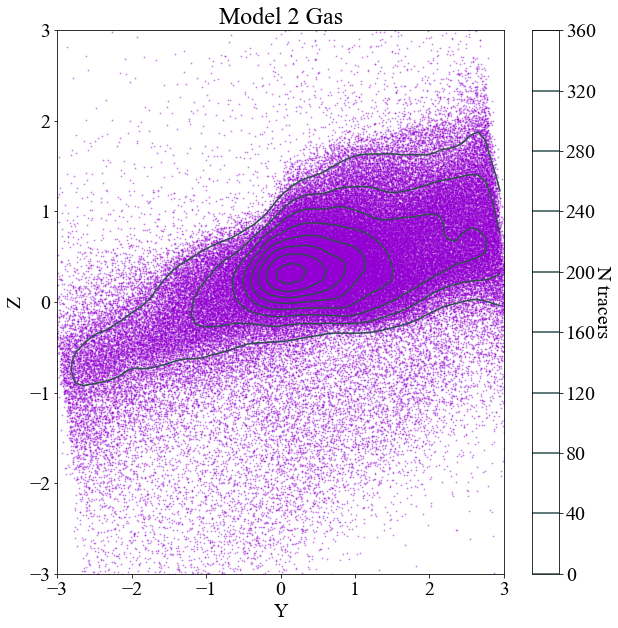

<Figure size 432x288 with 0 Axes>

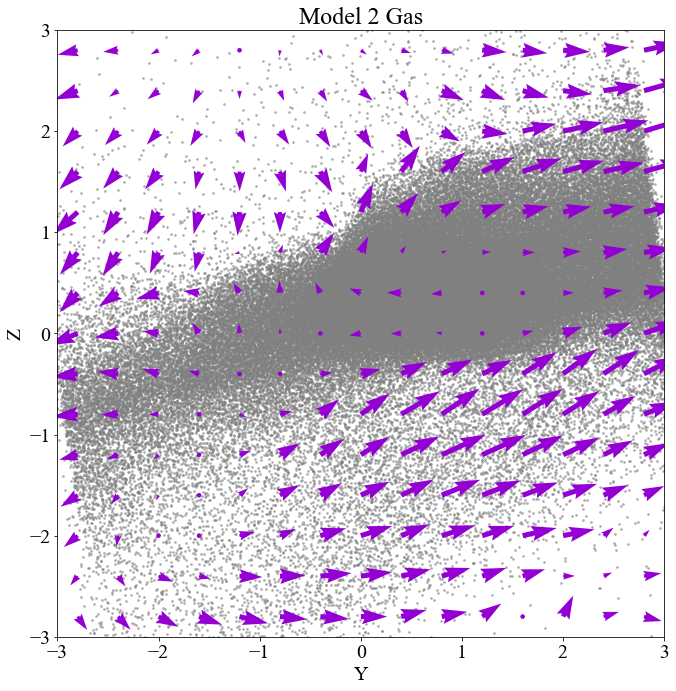

<Figure size 432x288 with 0 Axes>

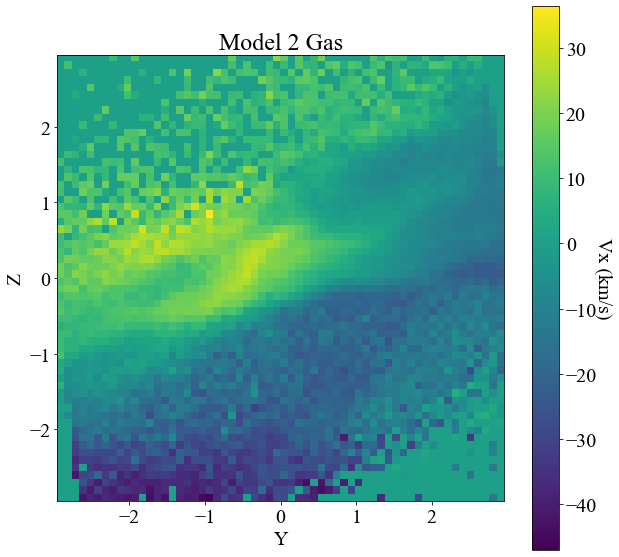

<Figure size 432x288 with 0 Axes>

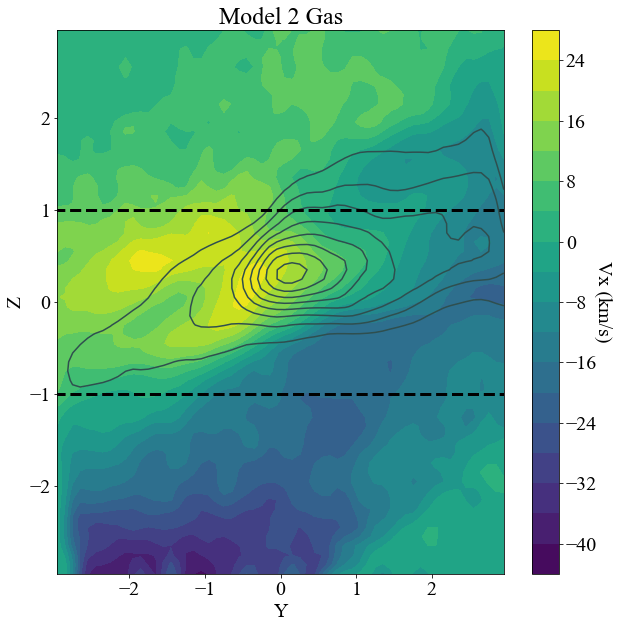

<Figure size 432x288 with 0 Axes>

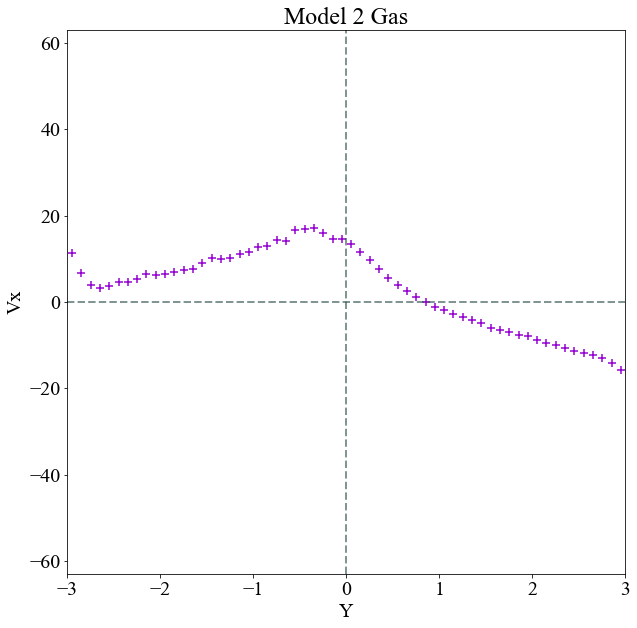

In [16]:
yz_ygrid2, yz_zgrid2, yz_ngrid2 = create_grid(model, 0.1, ymax, ymin, 0.1, \
                                             zmax, zmin, 'Y_1', 'Z_1', countn=True)

sigma=1.0

temp_n = scipy.ndimage.filters.gaussian_filter(yz_ngrid2, sigma)


#### First make a scatter plot of the stars in Y/Z

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model['Y_1'], model['Z_1'], s=plotsize, lw=0, marker='.', color=plotc, alpha=0.5)
cn = ax.contour(yz_ygrid2, yz_zgrid2, temp_n, levels=10, colors=contourcolor)

cbar = fig.colorbar(cn)
cbar.set_label("N tracers", rotation=270, labelpad=15)

ax.set_xlim(ymin, ymax)
ax.set_ylim(zmin, zmax)

ax.set_xlabel('Y')
ax.set_ylabel('Z')

ax.set_title(perm)

fig.savefig(dir + "Plots/"+plotdir+"/" + data + "_YZ.png", dpi=300, facecolor="white", edgecolor='none')

plt.show()


#### Next we'll bin the stars in this X/Y space and create Vx/Vy vectors to see the motion in the sky

yz_pmbins = vec_grid(model, ywidth, ymax, ymin, zwidth, zmax, zmin, 'Y_1', 'Z_1', 'Vy_1', 'Vz_1')

pmbiny, pmbinz, pmbinvy, pmbinvz = 0, 1, 2, 3


#### With vectors calculated, we'll take a look at them now

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model['Y_1'], model['Z_1'], s=plotsize, color="grey", marker=".", alpha=0.5)

q1 = ax.quiver(yz_pmbins[:,pmbiny], yz_pmbins[:,pmbinz], \
                (yz_pmbins[:,pmbinvy]), \
                (yz_pmbins[:,pmbinvz]), lw=2, \
                units="xy", scale_units='xy', color=plotc, \
                width=0.05)

ax.set_xlabel(r'Y')
ax.set_ylabel(r'Z')

ax.set_xlim(ymin, ymax)
ax.set_ylim(zmin, zmax)

ax.set_title(perm)
       
ax.set_aspect("equal")
plt.tight_layout()

fig.savefig(dir + "Plots/"+plotdir+"/" + data + "_YZ_vec.png", dpi=300, facecolor="white", edgecolor='none')

plt.show()


#### Now we'll bin the stars in this Y/Z space and calculate the average Vz_0 value in each bin

yz_ygrid, yz_zgrid, yz_vxgrid = create_grid(model, 0.1, ymax, ymin, 0.1, \
                                    zmax, zmin, 'Y_1', 'Z_1', zind='Vx_1')

distextent = (np.amin(yz_ygrid), np.amax(yz_ygrid), \
              np.amin(yz_zgrid), np.amax(yz_zgrid))


#### Now plot this map

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(yz_vxgrid, extent=distextent, origin='lower', \
                interpolation='nearest', cmap=my_cmap)

cbar = fig.colorbar(cax)
cbar.set_label("Vx (km/s)", rotation=270, labelpad=15)

ax.set_xlim(distextent[0], distextent[1])
ax.set_ylim(distextent[2], distextent[3])

ax.set_xlabel(r'Y')
ax.set_ylabel(r'Z')

ax.set_title(perm)

fig.savefig(dir + "Plots/"+plotdir+"/" + data + "_YZ_Vxbin.png", dpi=300, facecolor="white", edgecolor='none')

plt.show()


#### Now smooth it and plot it as a contour map

temp_vx = scipy.ndimage.filters.gaussian_filter(yz_vxgrid, sigma)

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

cp = ax.contourf(yz_ygrid, yz_zgrid, temp_vx, levels=20)
cn = ax.contour(yz_ygrid, yz_zgrid, temp_n, levels=10, colors=contourcolor)

cbar = fig.colorbar(cp)
cbar.set_label("Vx (km/s)", rotation=270, labelpad=15)

ax.plot(slitwindow[:,0], slitwindow[:,1], lw=3, linestyle='--', color='black')

ax.set_xlim(distextent[0], distextent[1])
ax.set_ylim(distextent[2], distextent[3])

ax.set_xlabel(r'Y')
ax.set_ylabel(r'Z')

ax.set_title(perm)

fig.savefig(dir + "Plots/"+plotdir+"/" + data + "_YZ_Vxsmooth.png", dpi=300, facecolor="white", edgecolor='none')

plt.show()


####

slitx, slity = slit_function(model, 0.1, ymax, ymin, zmax, zmin, 'Y_1', 'Z_1', zind='Vx_1')
ybound = 1.1*max(abs(slity))


plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(slitx, slity, s=80, marker='+', color=plotc)

#ax.plot([0.0, 0.0], [-1*ybound, ybound], lw=2, linestyle='--', color=contourcolor, alpha=0.6)
ax.plot([0.0, 0.0], [rvmin, rvmax], lw=2, linestyle='--', color=contourcolor, alpha=0.6)
ax.plot([xmin, xmax], [0.0, 0.0], lw=2, linestyle='--', color=contourcolor, alpha=0.6)

ax.set_xlim(ymin, ymax)
#ax.set_ylim(-1*ybound, ybound)
ax.set_ylim(rvmin, rvmax)

ax.set_xlabel(r'Y')
ax.set_ylabel(r'Vx')
ax.set_title(perm)

fig.savefig(dir+"Plots/"+plotdir+"/"+ data+"_Y_Vx_curve.png", dpi=300, facecolor='white', edgecolor='none')

plt.show()

##

yvx_vals = np.asarray([slitx, slity]).T

np.savetxt(dir+"Output/Slit_values/"+plotdir+"/"+data+"_yvx_vals.txt", yvx_vals, fmt="%1.5f")

In [15]:
vx_disp = np.std(model['Vx_1'])
vy_disp = np.std(model['Vy_1'])
vz_disp = np.std(model['Vz_1'])

print("The (Vx, Vy, Vz) dispersion components for " + perm + " are: ")
print(vx_disp, vy_disp, vz_disp)

The (Vx, Vy, Vz) dispersion components for Model 2 Gas are: 
15.814226301356872 26.8011604451713 12.853787922614277
